# QuTiP  example: Bloch-Redfield Master Equation

In [5]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

## Two-level system

In [30]:
delta       = .01 * 2 * np.pi
epsilon     = 0.5 * 2 * np.pi
gamma_0     = 0.5
gamma_phi   = 0.5

times = np.linspace(0, 10, 100)

In [31]:
atom_g = basis(2,0)
atom_e = basis(2,1)
sm     = atom_g * atom_e.dag()
sp     = sm.dag()
sx     = sm + sp
sy     = 1j * (sm - sp)
sz     = atom_e * atom_e.dag() - atom_g * atom_g.dag()

H = delta/2 * sx + epsilon * atom_e * atom_e.dag()
H

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.03141593]
 [0.03141593 3.14159265]]

In [32]:
psi0 = (2 * atom_e + atom_g).unit()
psi0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.4472136 ]
 [0.89442719]]

In [33]:
c_ops = [np.sqrt(gamma_0) * sm, np.sqrt(gamma_phi) * sz]
wc = 1
def ohmic_spectrum_at_decay(w):
    if w == 0:
        return gamma_phi
    else:
        return gamma_0 * (w>0.0)
    return gamma_0 * w/wc * np.exp(-w/wc) * (w > 0.0)
    return 5*gamma_0 / 2 * (w / (2 * np.pi)) * (w > 0.0)

def ohmic_spectrum_at_deph(w):
    return gamma_phi * (w>0.0)
    return gamma_phi * w/wc * np.exp(-w/wc) * (w > 0.0)
    return 5*gamma_phi / 2 * (w / (2 * np.pi)) * (w > 0.0)

a_op_list = [[sx, ohmic_spectrum_at_decay]] #, [sz, ohmic_spectrum_at_deph]

In [34]:
e_ops = [sx, sy, sz]

In [35]:
result_me = mesolve(H, psi0, times, c_ops, e_ops)

In [36]:
result_brme = brmesolve(H, psi0, times, a_ops=a_op_list, e_ops=e_ops)

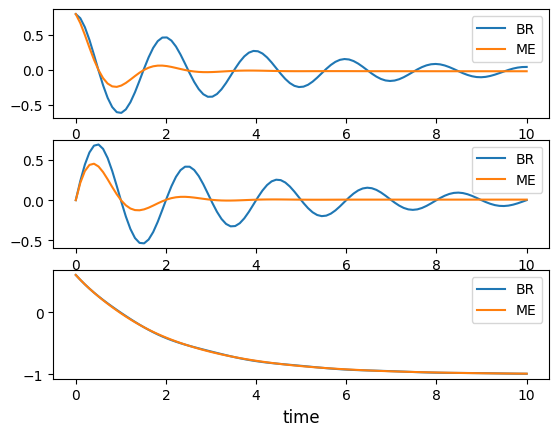

In [37]:
fig, axes = plot_expectation_values([result_brme, result_me])
for ax in axes:
    ax.legend(labels=["BR", "ME"])  # Adjust labels and location as needed
plt.show()

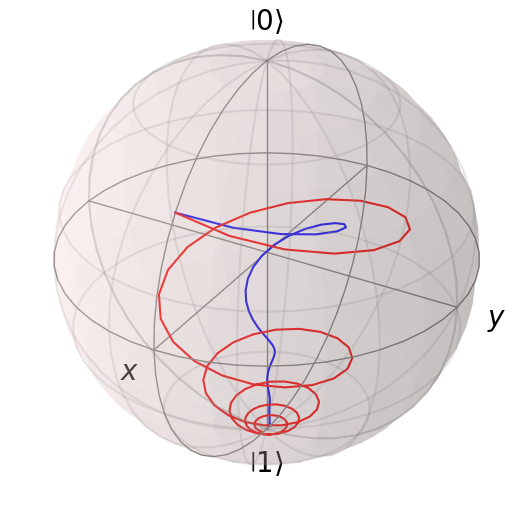

In [38]:
b = Bloch()
b.add_points(result_me.expect, meth='l')
b.add_points(result_brme.expect, meth='l')
b.make_sphere()

## Harmonic oscillator

In [39]:
N = 10

w0 = 1.0 * 2 * np.pi
g = 0.05 * w0
kappa = 0.15

times = np.linspace(0, 25, 1000)

In [40]:
a = destroy(N)

In [41]:
H = w0 * a.dag() * a + g * (a + a.dag())

In [42]:
# start in a superposition state
psi0 = ket2dm((basis(N, 4) + basis(N, 2) + basis(N,0)).unit())

In [43]:
c_ops = [np.sqrt(kappa) * a]
a_ops = [[a + a.dag(),lambda w : kappa * (w > 0)]]

In [44]:
e_ops = [a.dag() * a, a + a.dag()]

### Zero temperature

In [45]:
result_me = mesolve(H, psi0, times, c_ops, e_ops)

In [46]:
result_brme = brmesolve(H, psi0, times, a_ops, e_ops)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/brmesolve.py:169: FutureWarning: c_ops, e_ops, args and options will be keyword only from qutip 5.3
  warnings.warn(


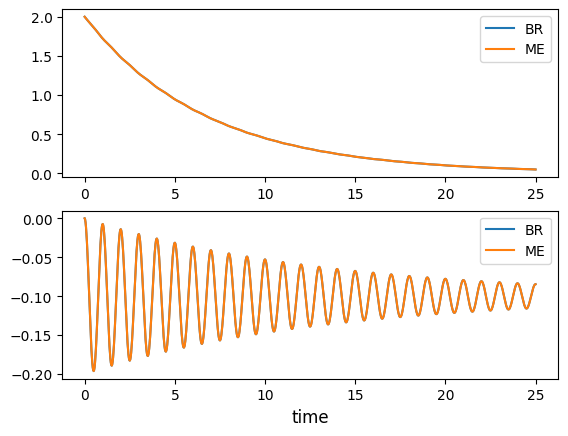

In [47]:
fig, axes = plot_expectation_values([result_brme, result_me])
for ax in axes:
    ax.legend(labels=["BR", "ME"])  # Adjust labels and location as needed
plt.show()

### Finite temperature

In [223]:
times = np.linspace(0, 25, 250)

In [76]:
n_th = 5
c_ops = [np.sqrt(kappa * (n_th + 1)) * a, np.sqrt(kappa * n_th) * a.dag()]

In [77]:
result_me = mesolve(H, psi0, times, c_ops, e_ops)

In [78]:
w_th = w0/np.log(1 + 1/n_th)

def S_w(w):
    if w >= 0:
        return (n_th + 1) * kappa
    else:
        return (n_th + 1) * kappa * np.exp(w / w_th)
    
a_ops = [[a + a.dag(),S_w]]

In [79]:
result_brme = brmesolve(H, psi0, times, a_ops, e_ops)

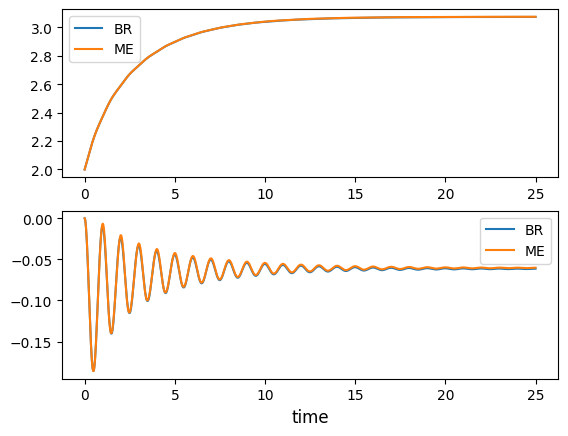

In [80]:
fig, axes = plot_expectation_values([result_brme, result_me])
for ax in axes:
    ax.legend(labels=["BR", "ME"])  # Adjust labels and location as needed
plt.show()

### Storing states instead of expectation values

In [229]:
result_me = mesolve(H, psi0, times, c_ops, [])

In [230]:
result_brme = brmesolve(H, psi0, times, a_ops, [])

In [231]:
n_me = expect(a.dag() * a, result_me.states)

In [232]:
n_brme = expect(a.dag() * a, result_brme.states)

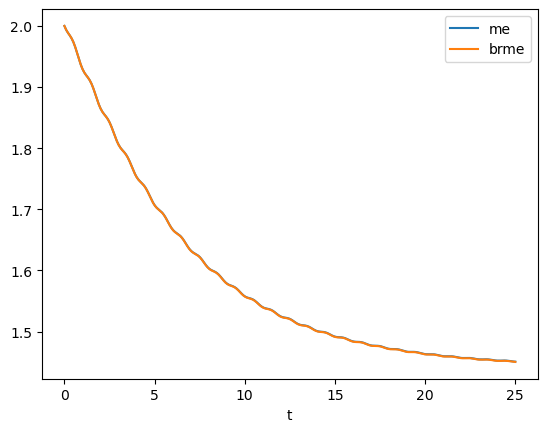

In [233]:
fig, ax = plt.subplots()

ax.plot(times, n_me, label='me')
ax.plot(times, n_brme, label='brme')
ax.legend()
ax.set_xlabel("t");

## Atom-Cavity

In [234]:
N = 10
a = tensor(destroy(N), identity(2))
sm = tensor(identity(N), destroy(2))
psi0 = ket2dm(tensor(basis(N, 1), basis(2, 0)))
e_ops = [a.dag() * a, sm.dag() * sm]

### Weak coupling

In [235]:
w0 = 1.0 * 2 * np.pi
g = 0.05 * 2 * np.pi
kappa = 0.05
times = np.linspace(0, 5 * 2 * np.pi / g, 1000)

a_ops = [[(a + a.dag()),lambda w : kappa*(w > 0)]]

In [236]:
c_ops = [np.sqrt(kappa) * a]
H = w0 * a.dag() * a + w0 * sm.dag() * sm + g * (a + a.dag()) * (sm + sm.dag())

In [237]:
result_me = mesolve(H, psi0, times, c_ops, e_ops)

In [238]:
result_brme = brmesolve(H, psi0, times, a_ops, e_ops)

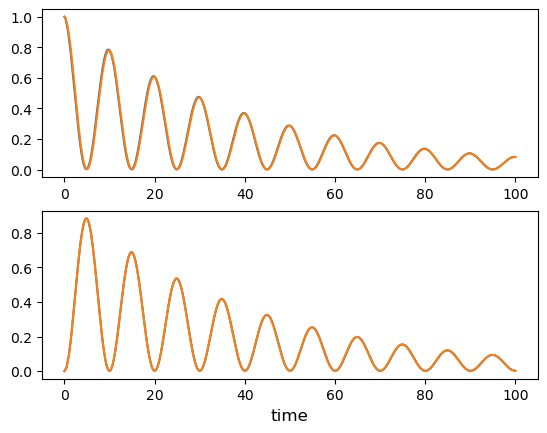

In [239]:
plot_expectation_values([result_me, result_brme]);

In the weak coupling regime there is no significant difference between the Lindblad master equation and the Bloch-Redfield master equation.

### Strong coupling

In [240]:
w0 = 1.0 * 2 * np.pi
g = 0.75 * 2 * np.pi
kappa = 0.05
times = np.linspace(0, 5 * 2 * np.pi / g, 1000)

In [241]:
c_ops = [np.sqrt(kappa) * a]
H = w0 * a.dag() * a + w0 * sm.dag() * sm + g * (a + a.dag()) * (sm + sm.dag())

In [242]:
result_me = mesolve(H, psi0, times, c_ops, e_ops)

In [243]:
result_brme = brmesolve(H, psi0, times, a_ops, e_ops)

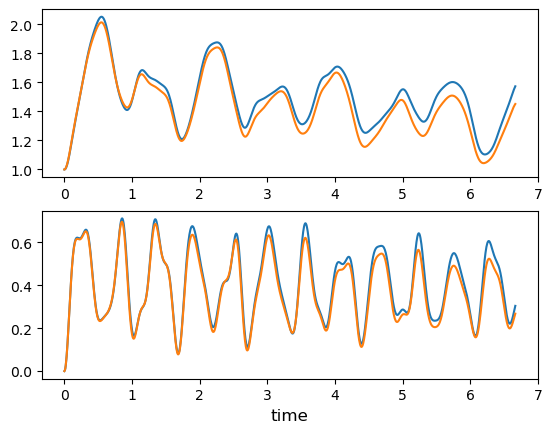

In [244]:
plot_expectation_values([result_me, result_brme]);

In the strong coupling regime there are some corrections to the Lindblad master equation that is due to the fact system eigenstates are hybridized states with both atomic and cavity contributions.

## Versions

In [245]:
from qutip.ipynbtools import version_table

version_table()